In [1]:
%matplotlib inline 
#to include graphs next to the code
#useful libraries
import numpy as np #linear algebra
import math
import pandas as pd #data processing
import matplotlib.pyplot as plt #plotting
import seaborn as sns #visualization


file='withoutcolumns.csv'
df = pd.read_csv(file)
print(df.describe()) #statistics 

         Unnamed: 0          index  ...  totalwalkingdistance  totalwaitingtime
count  85153.000000   85153.000000  ...          85153.000000      85153.000000
mean   42576.000000   49644.320294  ...              0.124514          4.723705
std    24581.698073   36107.436508  ...              0.195947         14.432200
min        0.000000       0.000000  ...              0.000000          0.000000
25%    21288.000000   21288.000000  ...              0.000000          0.000000
50%    42576.000000   42576.000000  ...              0.000000          0.000000
75%    63864.000000   66045.000000  ...              0.216000          1.330000
max    85152.000000  138243.000000  ...              0.965000        212.860000

[8 rows x 7 columns]


In [2]:
#redundant column via reading
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [3]:
df.rename({'totaltraveltimeinsec': 'totaltraveltimeinhours'}, axis=1, inplace=True)
df

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,objective,finiteautomaton,consideredpreferences,finalsolutionusedlabels,sourcename,targetname
0,3.93,0.86,0,0.000,0.00,price,all,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
1,1.33,2.17,0,0.000,0.00,price,all,"[travelTime, price]",[db_fv],Essen,Gelsenkirchen
2,1.33,2.17,0,0.000,0.00,travelTime,all,"[travelTime, price]",[db_fv],Essen,Gelsenkirchen
3,3.93,0.86,0,0.000,0.00,travelTime,all,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
4,3.93,0.86,0,0.000,0.00,price,ptOnly,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
...,...,...,...,...,...,...,...,...,...,...,...
85148,51.67,91.20,1,0.000,6.83,waitingTime,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],Würzburg,Oberhausen
85149,61.33,86.04,1,0.000,15.33,waitingTime,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],Würzburg,Oberhausen
85150,45.39,22.47,1,0.177,2.54,numberofChanges,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",Würzburg,Oberhausen
85151,45.39,22.47,1,0.177,2.54,walkingDistance,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",Würzburg,Oberhausen


In [4]:
#we do not have missing values, because we use the previous approach with 0s for them for the trial clustering round
df.isna().sum()

totaltraveltimeinhours     0
totalprice                 0
totalnumberofchanges       0
totalwalkingdistance       0
totalwaitingtime           0
objective                  0
finiteautomaton            0
consideredpreferences      0
finalsolutionusedlabels    0
sourcename                 0
targetname                 0
dtype: int64

In [5]:
#define what columns we need to drop for the clustering
# goal is to cluster the group of trips and see maybe we can detect some new patterns in the data based on clusters
#was decided to drop column objective-super low degree of association-0,05.. doesnt have any meaningfull information for clustering
#we have completely identical rows with all numerical/categorical variables (having the same labesls) with difference only in objective=> it doesnt change anything
#it also repeats somehow the combinations inside the 'considered preferences" column, whoch we will use for clustering

#drop sourcename and targetname for the algorithm- we would need to consider the groups of trips in Germany in general


df.drop(df.columns[[5, 9, 10]], axis = 1, inplace = True)

In [6]:
#the duplicated were removed
df.drop_duplicates(keep='last', inplace=True)

In [7]:
#from 85153 to 30199 thousands of rows (mainly because of reducing the objective column)
df

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv]
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus]
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus]
...,...,...,...,...,...,...,...,...
85147,36.33,106.46,1,0.000,4.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85148,51.67,91.20,1,0.000,6.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85149,61.33,86.04,1,0.000,15.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85151,45.39,22.47,1,0.177,2.54,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]"


In [ ]:
#try 2 combinations for dbscan- only involving numerical data and numerical + encoded categorical columns since encoding could distort the clusters
#use label encoding for the column considered preferences because it has the order

#use one hot encoding for finitiautomation and labels (or drop the labels)

In [8]:
encoding=df.copy()

In [9]:
from sklearn.preprocessing import LabelEncoder #encode the values
labelencoder = LabelEncoder()

#use label encoding for the column considered preferences because it has the order
encoding['consideredpreferences'] = labelencoder.fit_transform(encoding['consideredpreferences'])#Fit label encoder and return encoded labels for the first target column
#use label encoding because we have too many values for one hot encoding for solutionlabels-33 unique combinatios
encoding['finalsolutionusedlabels'] = labelencoder.fit_transform(encoding['finalsolutionusedlabels'])#Fit label encoder and return encoded labels for the second one

encoding.head(10)

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels
2,1.33,2.17,0,0.0,0.0,all,3,19
3,3.93,0.86,0,0.0,0.0,all,3,32
6,1.33,2.89,0,0.0,0.0,ptOnly,3,19
7,1.33,2.17,0,0.0,0.0,ptOnly,3,19
8,3.93,0.86,0,0.0,0.0,ptOnly,3,32
11,1.33,2.89,0,0.0,0.0,noFlights,3,19
12,1.33,2.17,0,0.0,0.0,noFlights,3,19
13,3.93,0.86,0,0.0,0.0,noFlights,3,32
18,2.53,3.83,0,0.0,0.0,all,2,6
20,1.33,2.89,0,0.0,0.0,all,2,19


In [ ]:
#In the case of one-hot encoding, for N categories in a variable, it uses N binary variables. 
#The dummy encoding is a small improvement over one-hot-encoding, uses N-1 features to represent N labels/categories.
#references are here 
#https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

#We apply One-Hot Encoding when:

#The categorical feature is not ordinal (like the countries above)
#The number of categorical features is less so one-hot encoding can be effectively applied
#We apply Label Encoding when:

#The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
#The number of categories is quite large as one-hot encoding can lead to high memory consumption

In [10]:
#we got our transformed dataset to plug it into dbscan algorithm and check the clusters
#use all the features to cluster the observations
categorical_col= ["finiteautomaton"]
transformed = pd.get_dummies(encoding, columns=categorical_col)#convert categorical target our automation

#check what we have got as the result
transformed.head(10)

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,consideredpreferences,finalsolutionusedlabels,finiteautomaton_all,finiteautomaton_noFlights,finiteautomaton_ptOnly
2,1.33,2.17,0,0.0,0.0,3,19,1,0,0
3,3.93,0.86,0,0.0,0.0,3,32,1,0,0
6,1.33,2.89,0,0.0,0.0,3,19,0,0,1
7,1.33,2.17,0,0.0,0.0,3,19,0,0,1
8,3.93,0.86,0,0.0,0.0,3,32,0,0,1
11,1.33,2.89,0,0.0,0.0,3,19,0,1,0
12,1.33,2.17,0,0.0,0.0,3,19,0,1,0
13,3.93,0.86,0,0.0,0.0,3,32,0,1,0
18,2.53,3.83,0,0.0,0.0,2,6,1,0,0
20,1.33,2.89,0,0.0,0.0,2,19,1,0,0


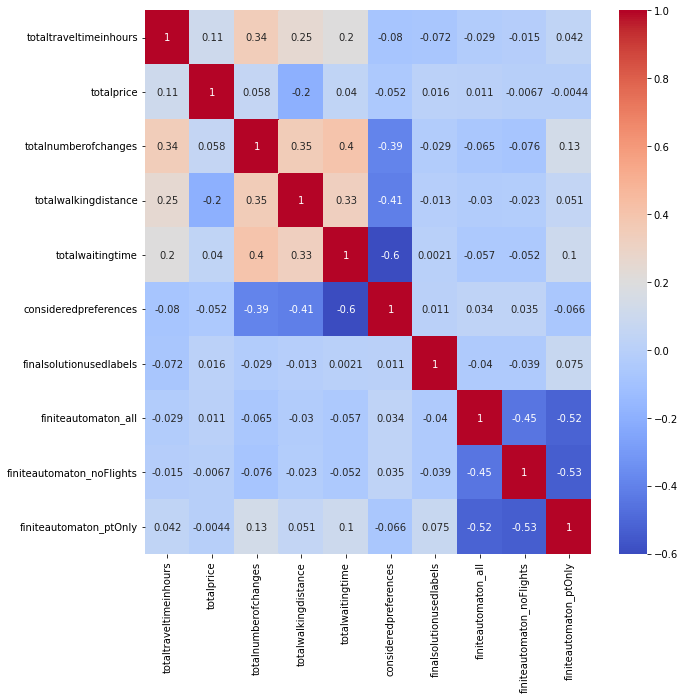

In [11]:
#create the second correlation matrix using our transformed categorical data
show=transformed.corr(method='kendall')#pairwise correlation
plt.figure(figsize=(10,10))
sns.heatmap(show,annot=True,cmap='coolwarm')

# reference:https://www.statisticssolutions.com/pearsons-correlation-coefficient/
# meaning of correlation number
# Perfect: If the value is near ± 1, then it said to be a perfect correlation
# High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.
# Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation.
# Low degree: When the value lies below ± 0.29, then it is said to be a small correlation.
# No correlation: When the value is zero


# no strong correlation between transformed categorical and numerical was detected

In [14]:
#import further libraries for DBscan
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn import metrics # for calculating Silhouette score

import matplotlib.pyplot as plt # for data visualization
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization

from sklearn.cluster import DBSCAN

In [128]:
# plotting in 3d scatter plot just with the observations before clustering
# we will assign the clusters there afterwards
fig = px.scatter_3d(transformed, x=transformed['totalprice'], y=transformed['totaltraveltimeinhours'], z=transformed['totalnumberofchanges'],
                 opacity=1, color_discrete_sequence=['green'], height=900, width=900)

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='blue',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='blue',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='blue', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

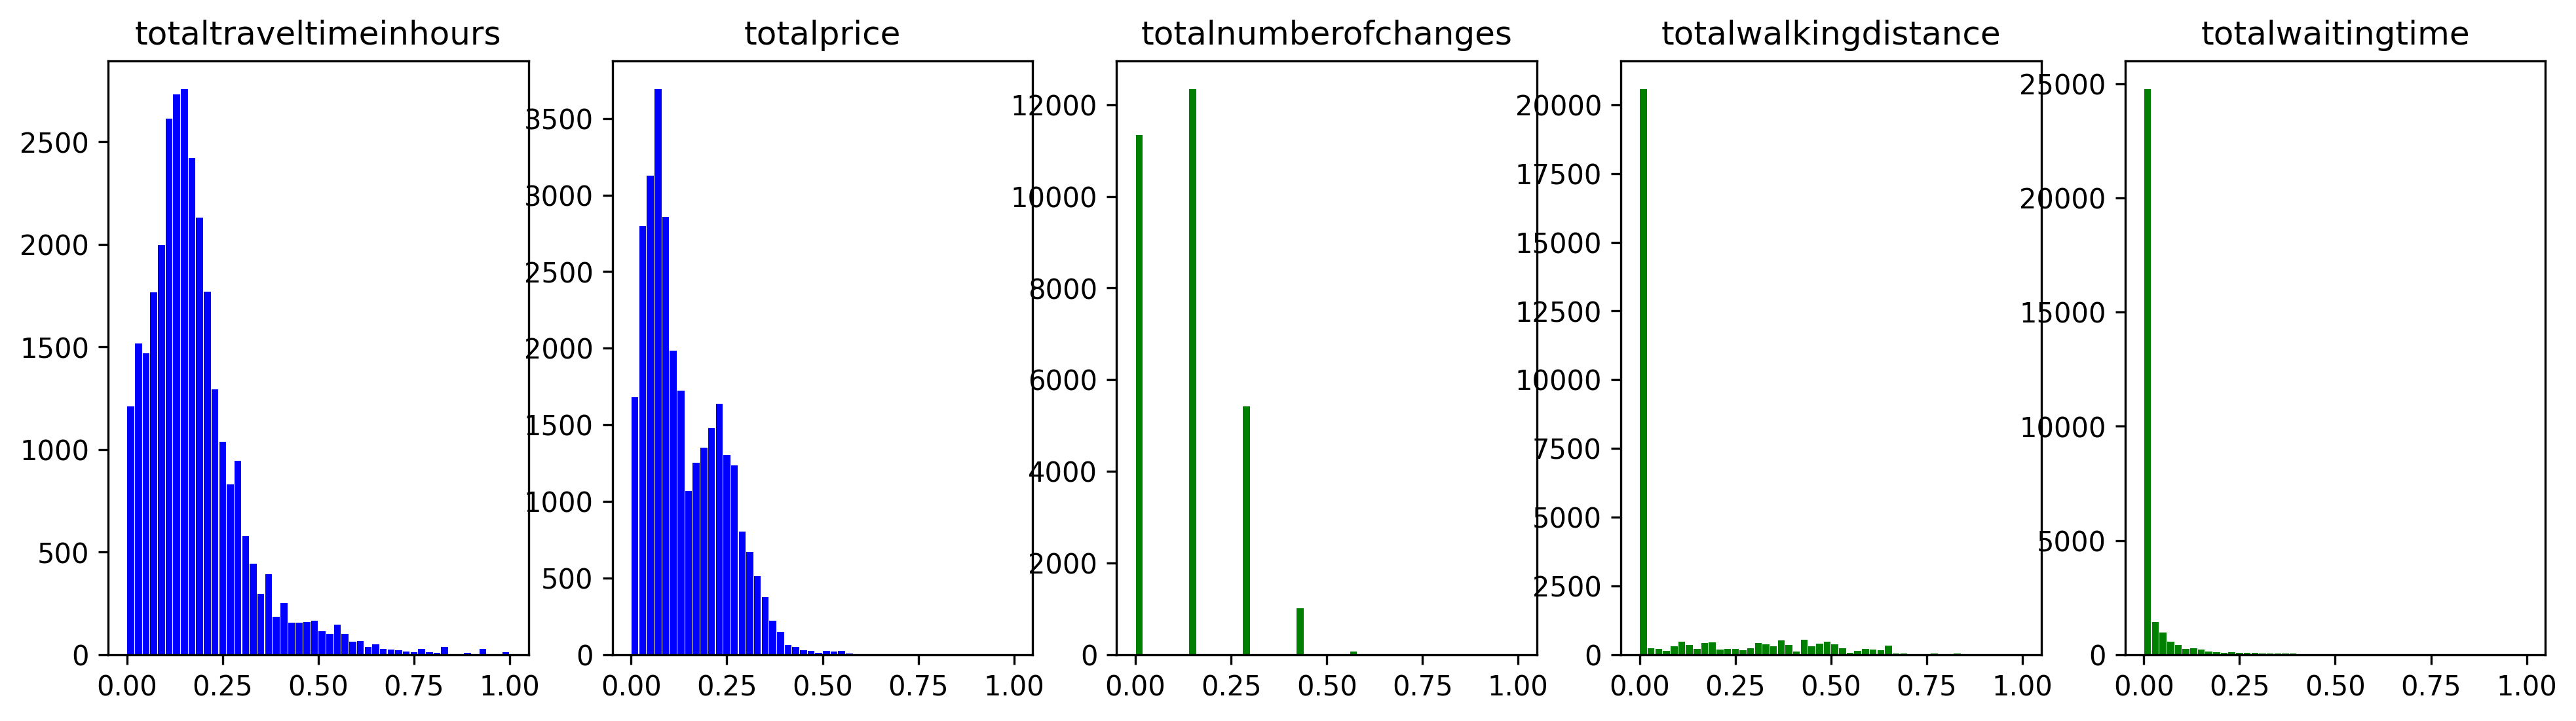

In [24]:
#to scale the features used min max scaler because data distribution is not normal (not fit a gaussian distribution)
scaler = MinMaxScaler()
transformed_scaled = scaler.fit_transform(transformed)

# plot the min max scaled distributions (dataset is combined)
#checked that all of them are between 1 and 0
fig, axs = plt.subplots(1, 5, figsize=(16,4), dpi=300)
axs[0].hist(transformed_scaled[:,0], bins=50, color='blue', rwidth=0.9)
axs[0].set_title('totaltraveltimeinhours')
axs[1].hist(transformed_scaled[:,1], bins=50, color='blue', rwidth=0.9)
axs[1].set_title('totalprice')
axs[2].hist(transformed_scaled[:,2], bins=50, color='green', rwidth=0.9)
axs[2].set_title('totalnumberofchanges')
axs[3].hist(transformed_scaled[:,3], bins=50, color='green', rwidth=0.9)
axs[3].set_title('totalwalkingdistance')
axs[4].hist(transformed_scaled[:,4], bins=50, color='green', rwidth=0.9)
axs[4].set_title('totalwaitingtime')

plt.show()

In [35]:
#check the array
transformed_scaled

array([[6.02942359e-04, 4.00530357e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10539432e-02, 3.86718966e-04, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.02942359e-04, 5.99414397e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [2.41779886e-01, 2.35677587e-01, 1.42857143e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.77707211e-01, 6.00795536e-02, 1.42857143e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.40646354e-01, 2.99154743e-01, 1.42857143e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [46]:
#check the shape
transformed_scaled.shape

(30199, 10)

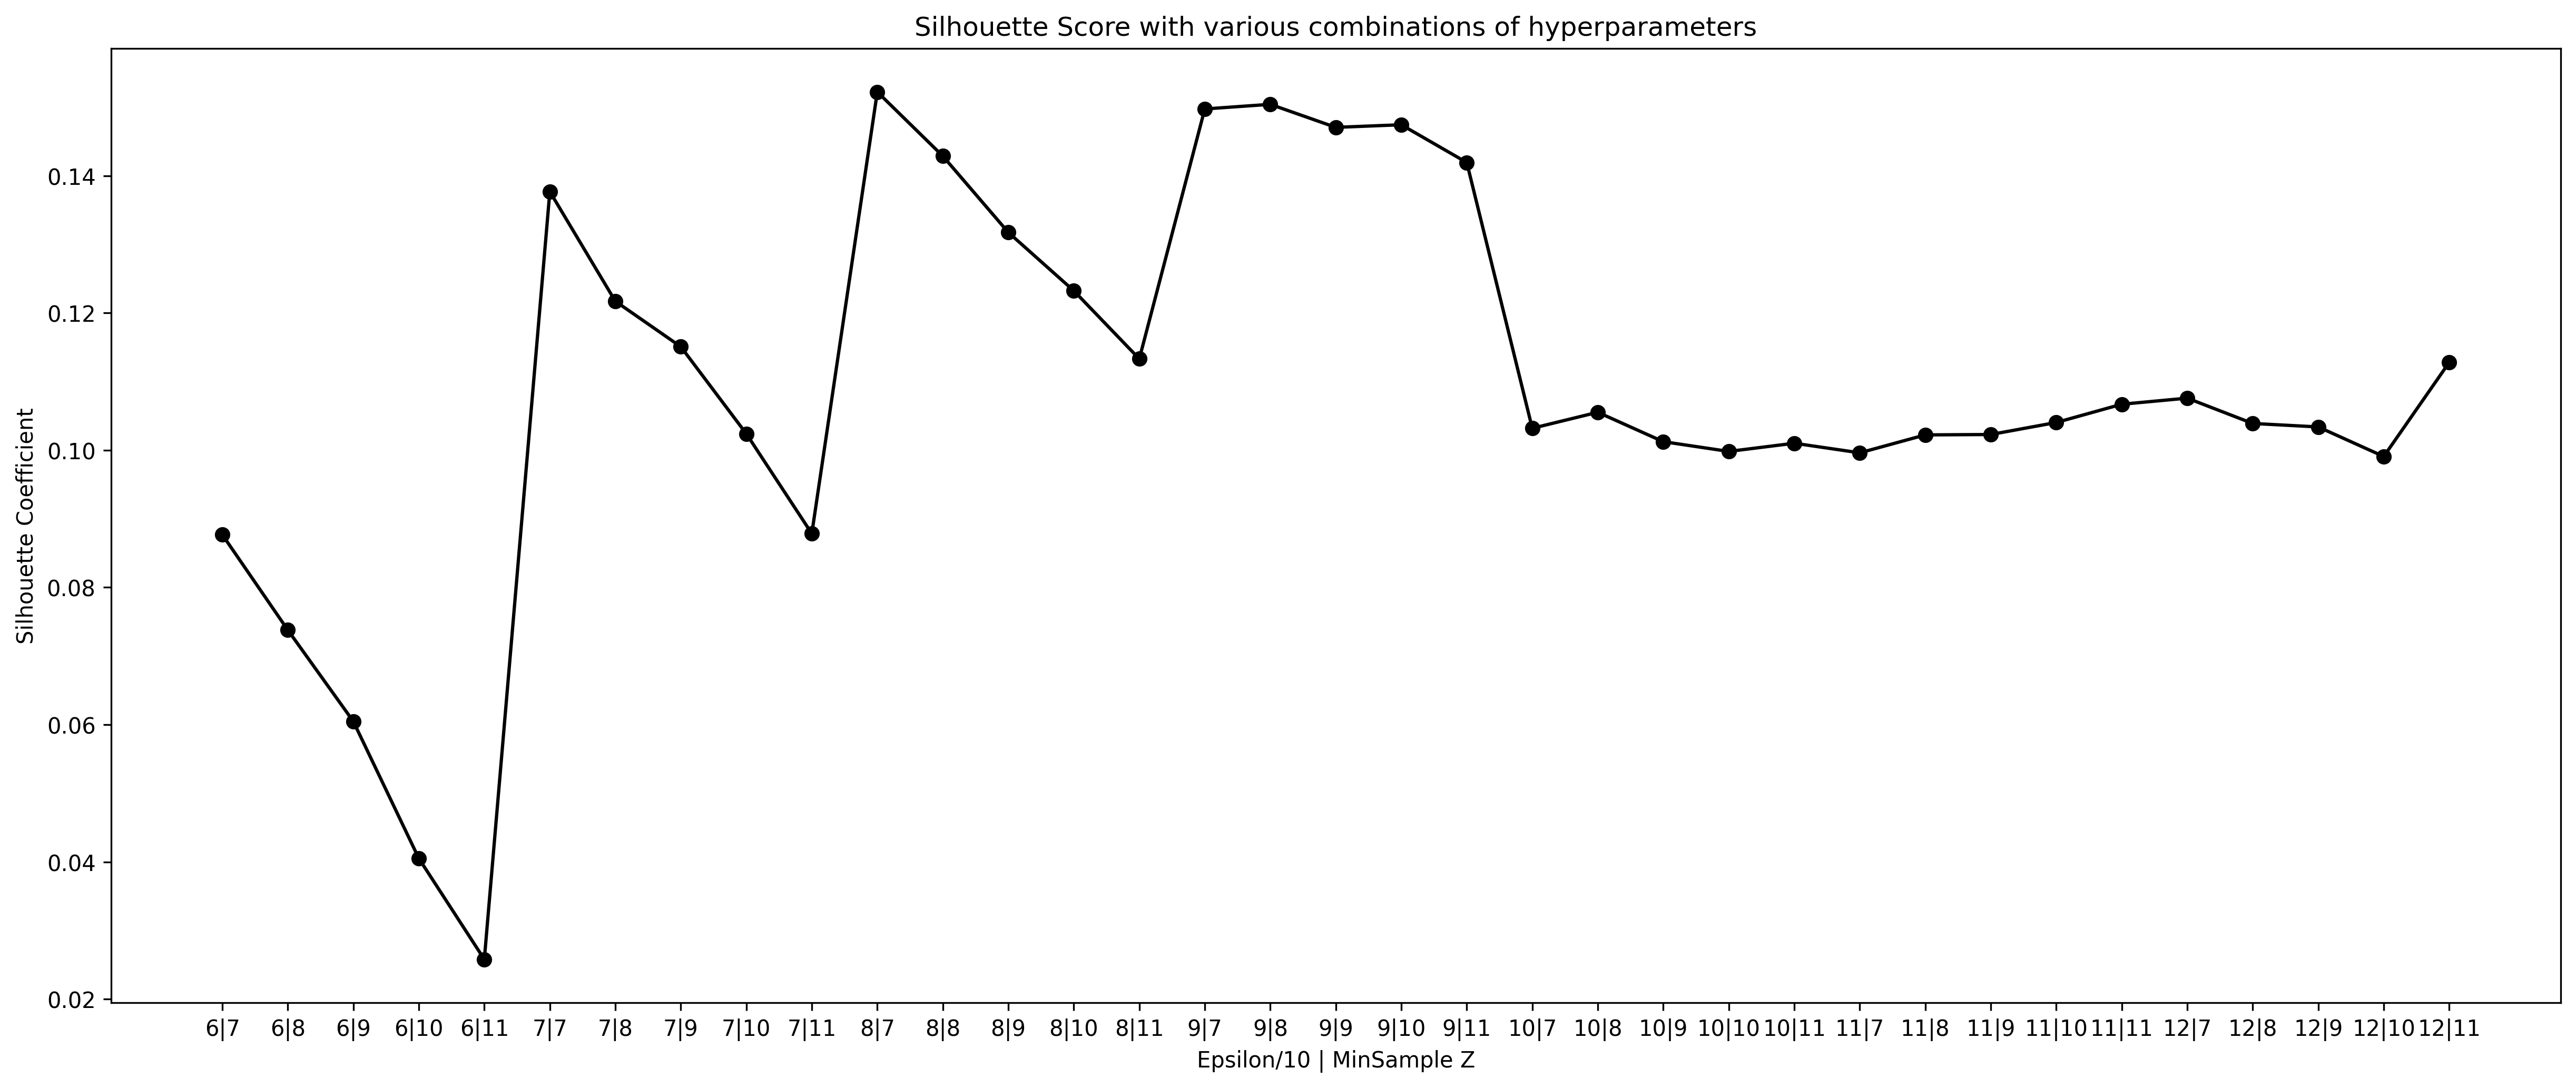

In [153]:
#test different hyperparameter values for DBscan
# empty lists
# to store inside different Silhouette scores
SS=[] # to store inside different Silhouette scores
# to save results of various epsilon and min_samples
combinations=[] 

# ranges to choose
# we will choose different suitables ranges to test
eps_range=range(6,13) # 0.6 - 1.3 range
#rule of thumb-choose based on number of dimensions-before scaling it was 7, now its 9, try out other options
minpts_range=range(7,12)

for k in eps_range:
    for j in minpts_range:
        # model and parameters
        model = DBSCAN(eps=k/10, min_samples=j)
        # fitting the model 
        clm = model.fit(transformed_scaled)
        # calculation of Silhoutte Score and appending it to the list
        SS.append(metrics.silhouette_score(transformed_scaled, clm.labels_, metric='euclidean'))
        combinations.append(str(k)+"|"+str(j)) # axis values for the graph

# plotting the results of Silhouette scores to make a decision
plt.figure(figsize=(20,8), dpi=300)
plt.plot(combinations, SS, 'bo-', color='black')
plt.xlabel('Epsilon/10 | MinSample Z')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Score with various combinations of hyperparameters')
plt.show()

#running time is 20 minutes
# we can conclude that epsilon 0,8 and 7 minpts produce the highest silhouette score, but still the value of 0,15 is really low


In [94]:
#eventually use for the model: eps=0.8, MinPts=7

modeldb = DBSCAN(eps=0.8, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=7, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=None, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )



# fit our model
clustm = modeldb.fit(transformed_scaled)


# check the results
print('DBSCAN Clustering Model ')
print("Cluster labels for the first model")
print(clustm.labels_)

#3 clusters were formed, having no -1 means that we have no noise being identified by the algorithm



DBSCAN Clustering Model 
Cluster labels for the first model
[0 0 1 ... 1 2 2]


In [96]:
#assign clusters to the data frame for further analysis of groups via plots
df['DBSCAN cluster']=clustm.labels_
df

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,DBSCAN cluster
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv],0
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus],0
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus],1
...,...,...,...,...,...,...,...,...,...
85147,36.33,106.46,1,0.000,4.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1
85148,51.67,91.20,1,0.000,6.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1
85149,61.33,86.04,1,0.000,15.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1
85151,45.39,22.47,1,0.177,2.54,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",2


In [105]:
# plot the clusters in 3d environment with the colors assigned per cluster
df=df.sort_values(by=['DBSCAN cluster'])

# 3d scatter plot
fig = px.scatter_3d(df, x=df['totalprice'], y=df['totaltraveltimeinhours'], z=df['totalnumberofchanges'], 
                    opacity=1, color=df['DBSCAN cluster'].astype(str), 
                    color_discrete_sequence=['black']+px.colors.qualitative.Plotly,
                    hover_data=['totalwalkingdistance', 'totalwaitingtime'],
                    width=900, height=900
                   )

# chart
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=0.04, xanchor="left", x=0.1),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# change marker size
fig.update_traces(marker=dict(size=2))

fig.show()

#with the silhouette 0,15 we can conclude that clusters are indifferent since the distance between them is not really significant


In [121]:
#check how many instances belong to the cluster
print(pd.Series(clustm.labels_).value_counts())



1    11530
2     9527
0     9142
dtype: int64


In [ ]:
df['DBSCAN cluster']=clustm.labels_

In [106]:
#0,1,2 our 3 groups
clustm.labels_

array([0, 0, 1, ..., 1, 2, 2])

In [120]:
#to plot 2 dimensions
dbscan=DBSCAN(eps=0.8, min_samples=7)

In [122]:
lables=dbscan.fit_predict(transformed_scaled)

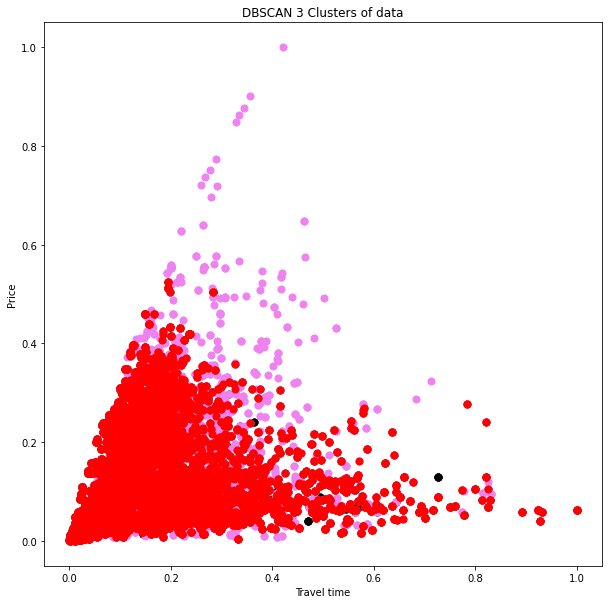

In [127]:
#2 dimensions
lables=dbscan.fit_predict(transformed_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(transformed_scaled[lables == 0, 0], transformed_scaled[lables == 0, 1], s = 50, c = 'black')
plt.scatter(transformed_scaled[lables == 1, 0], transformed_scaled[lables == 1, 1], s = 50, c = 'violet')
plt.scatter(transformed_scaled[lables == 2, 0], transformed_scaled[lables == 2, 1], s = 50, c = 'red')

plt.xlabel('Travel time')
plt.ylabel('Price')
plt.title('DBSCAN 3 Clusters of data')
plt.show()

In [109]:
#three unique clusters
np.unique(lables)

array([0, 1, 2])

In [133]:
#form the group for cluster 1
cluster_1= df[df['DBSCAN cluster']== 0]
cluster_1.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,DBSCAN cluster
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv],0
7856,47.49,124.21,0,0.000,0.00,all,"[travelTime, price, numberofChanges, walkingDi...",[car],0
7854,29.33,126.53,1,0.000,0.00,all,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],0
7841,128.71,41.73,1,0.129,0.00,all,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, blablacar]",0
80960,12.33,22.71,0,0.000,0.00,all,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],0
80961,11.83,29.66,0,0.000,0.00,all,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],0
7812,47.49,124.21,0,0.000,0.00,all,"[travelTime, price, numberofChanges]",[car],0
7811,53.71,41.73,1,0.000,0.00,all,"[travelTime, price, numberofChanges]","[db_fv, blablacar]",0
7809,29.33,126.53,1,0.000,0.00,all,"[travelTime, price, numberofChanges]",[db_fv],0
7798,93.71,41.73,1,0.000,0.00,all,"[travelTime, price, numberofChanges]","[db_fv, blablacar]",0


In [137]:
#form the group for cluster 2
cluster_2= df[df['DBSCAN cluster']== 1]
cluster_2.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,DBSCAN cluster
37999,121.21,35.73,1,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]","[db_fv, blablacar]",1
38179,88.05,73.89,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",1
38001,32.87,55.43,1,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]","[db_fv, blablacar]",1
9812,33.33,63.13,0,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1
9738,56.05,50.16,1,0.213,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, blablacar]",1
38000,41.21,35.73,1,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]","[db_fv, blablacar]",1
9956,91.13,23.37,0,0.000,0.00,ptOnly,"[travelTime, price]","[db_fv, blablacar, flixbus]",1
37847,38.47,23.13,0,0.487,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[flixbus],1
37799,38.47,23.13,0,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]",[flixbus],1
9478,51.63,16.77,1,0.495,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[flixbus, blablacar]",1


In [139]:
#form the group for cluster 3
cluster_3= df[df['DBSCAN cluster']== 2]
cluster_3.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,DBSCAN cluster
50117,89.84,18.35,1,0.170,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[flixbus, blablacar]",2
50116,90.31,18.31,1,0.406,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[flixbus, blablacar]",2
50114,56.81,20.59,1,0.096,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, blablacar]",2
58332,61.83,18.34,2,0.000,0.00,noFlights,"[travelTime, price, numberofChanges]","[db_fv, blablacar, db_fv]",2
50113,30.67,42.22,0,0.000,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2
50112,55.17,50.36,1,0.000,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2
50111,34.17,51.67,1,0.000,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2
50110,55.17,54.86,1,0.000,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2
58270,12.00,27.50,0,0.000,0.00,noFlights,"[travelTime, price]",[db_fv],2
50109,29.00,59.82,0,0.000,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2


In [140]:
def minvalue(data):
  minvalue = data[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].min()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(minvalue)

minvalue(cluster_1)
minvalue(cluster_2)
minvalue(cluster_3)


minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    1.18
totalwaitingtime          0.00
totalnumberofchanges      0.00
totalwalkingdistance      0.00
totalprice                0.72
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    1.18
totalwaitingtime          0.00
totalnumberofchanges      0.00
totalwalkingdistance      0.00
totalprice                0.72
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    1.18
totalwaitingtime          0.00
totalnumberofchanges      0.00
totalwalkingdistance      0.00
totalprice                0.72
dtype: float64


In [141]:
#investigate the group with respect to max value
def maxvalue(d):
  maxvalue = d[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].max()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(maxvalue)

maxvalue(cluster_1)
maxvalue(cluster_2)
maxvalue(cluster_3)


#the range would be from 1 hour to 47 hours,0-36 waiting hours, 0-5 changes,0-0.745 walking distance, 0.72-50.840 for the price

minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    249.960
totalwaitingtime          208.790
totalnumberofchanges        4.000
totalwalkingdistance        0.965
totalprice                185.760
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    249.960
totalwaitingtime          212.860
totalnumberofchanges        7.000
totalwalkingdistance        0.965
totalprice                362.740
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    249.960
totalwaitingtime          212.860
totalnumberofchanges        4.000
totalwalkingdistance        0.965
totalprice                190.730
dtype: float64


In [142]:
#investigate the group with respect to mean value
#no distinctive mean
def meanvalue(dat):
  meanvalue = dat[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].mean()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(meanvalue)

meanvalue(cluster_1)
meanvalue(cluster_2)
meanvalue(cluster_3)


#values in general

minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    43.370101
totalwaitingtime           3.850611
totalnumberofchanges       0.798512
totalwalkingdistance       0.098476
totalprice                51.478508
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    47.012977
totalwaitingtime           5.993514
totalnumberofchanges       1.027667
totalwalkingdistance       0.117806
totalprice                51.479696
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    44.754373
totalwaitingtime           4.313395
totalnumberofchanges       0.781778
totalwalkingdistance       0.102674
totalprice                50.528976
dtype: float64


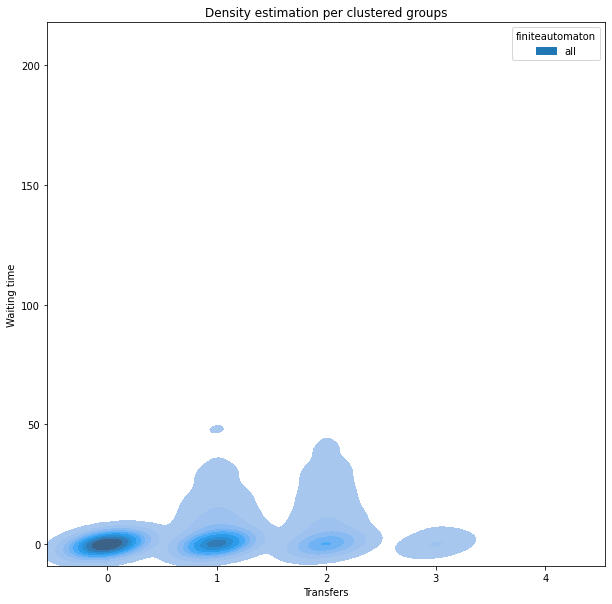

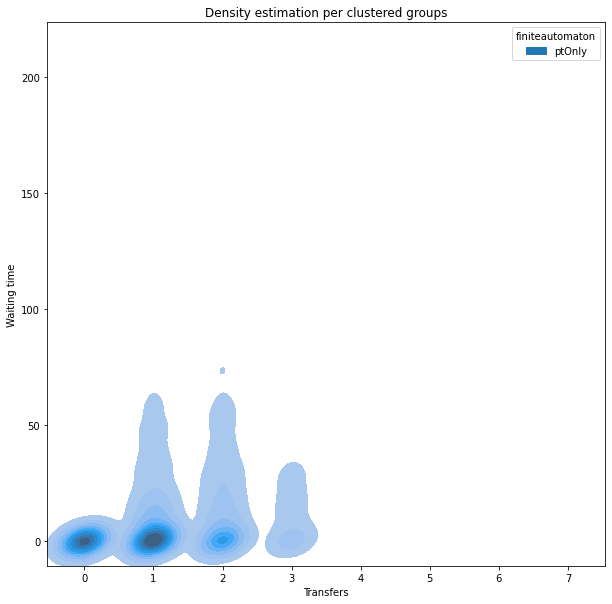

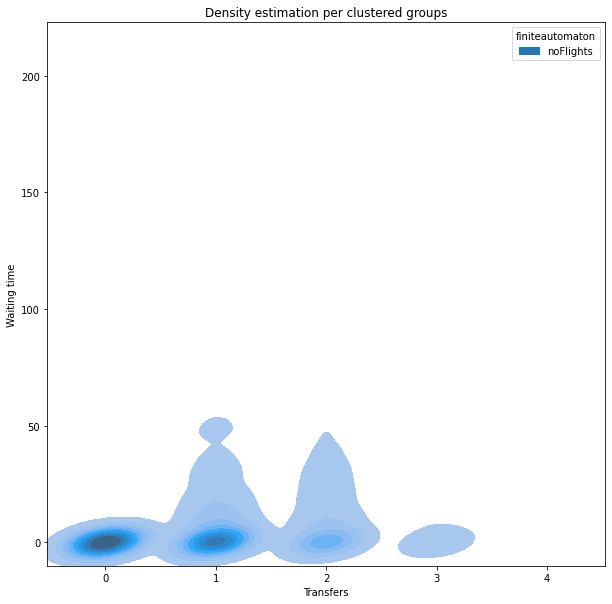

In [157]:
#after dbscan got the groups per mode of transportation
#1st group is about all types of transport
#2d group is public only
#3d group without any flights
def plot1(data):
  plt.figure(figsize=(10,10))#check the size
  sns.kdeplot(x=data.totalnumberofchanges,y=data.totalwaitingtime,hue=data.finiteautomaton,shade=True)
  plt.title('Density estimation per clustered groups')
  plt.xlabel('Transfers')
  plt.ylabel("Waiting time")

plot1(cluster_1)
plot1(cluster_2)
plot1(cluster_3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



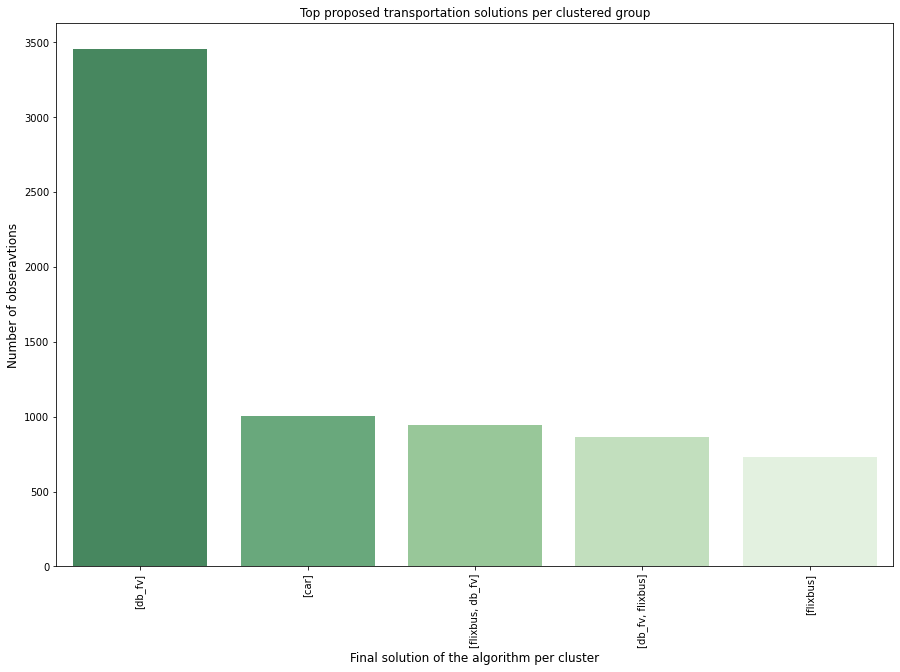

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



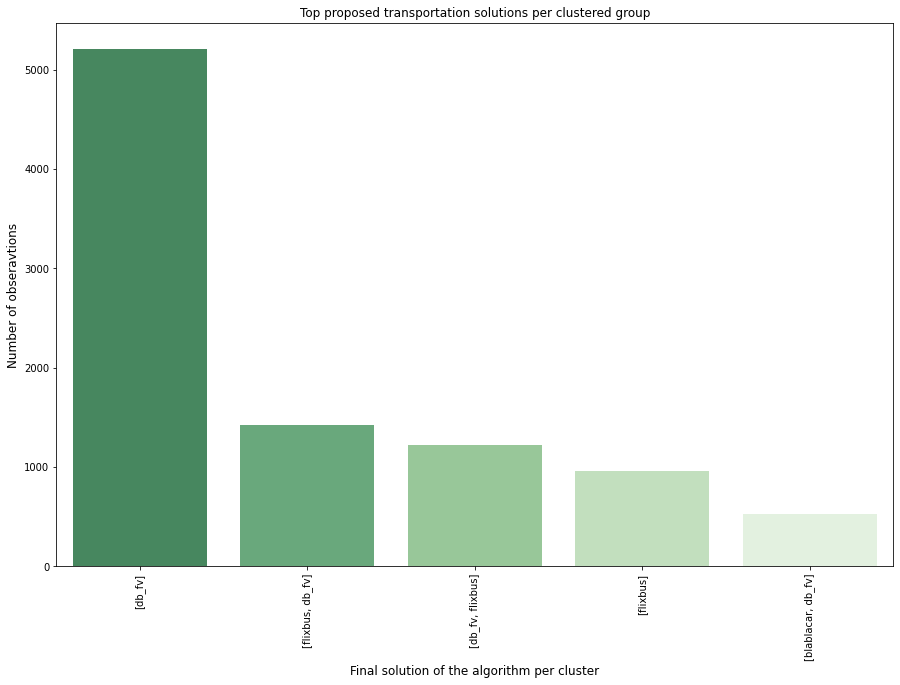

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



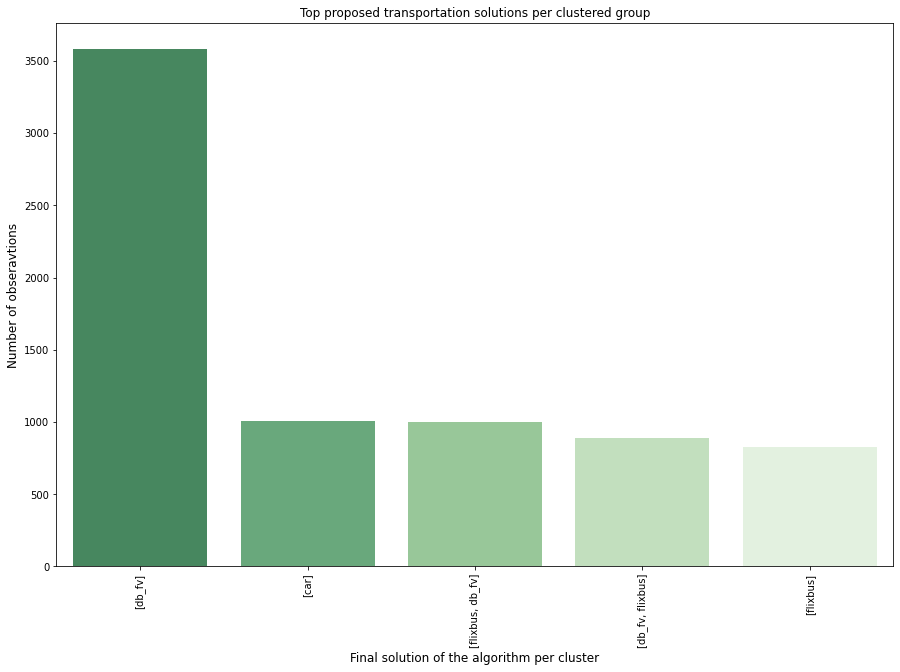

In [152]:
def plot6(data):
# top proposed solutions-normalyy the 1st is train, next the ratio is changeable
  cnt_srs = data['finalsolutionusedlabels'].value_counts().nlargest(5)
  plt.figure(figsize=(15,10))
  sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette="Greens_r")
  plt.title('Top proposed transportation solutions per clustered group')
  plt.xticks(rotation='vertical')
  plt.xlabel('Final solution of the algorithm per cluster', fontsize=12)
  plt.ylabel('Number of obseravtions', fontsize=12)
  plt.show()

plot6(cluster_1)
plot6(cluster_2)
plot6(cluster_3)
